# BiLSTM vs. BiLSTM-CRF for Named Entity Recognition on the CoNLL Dataset <br><br>


### <b>Paper:</b> BiDirectional-LSTM-CRF Models for Sequence Tagging by Huang et. al.
### <b>Dataset:</b> https://www.clips.uantwerpen.be/conll2003/ner/ <br><br>


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
from typing import List, Tuple, Dict
import logging
import requests
import os
from tqdm import tqdm
import json

# 1) Dataset Preparation

## 1.1) Download CoNLL Dataset

In [ ]:
def download_conll2003():
    # 1) Download the dataset
    # 2) Differentiate paths into Train, Validation, and Test

    # Links
    base_url = "https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/"
    files = ['eng.train', 'eng.testa', 'eng.testb']

    # Create directory if it doesnt exist
    if not os.path.exists('data'):
        os.makedirs("data")

    # Download files
    file_paths = []
    for file in files:
        path = f"data/{file}"
        file_paths.append(path)

        if os.path.exists(path):
            # If already present
            continue

        # Download
        response = requests.get(f"{base_url}{file}")
        with open(path, "wb") as f:
            f.write(response.content)

    return file_paths



## 1.2) Load CoNLL Dataset

In [ ]:
def load_dataset(file_path):
    # 1) Load and Process CoNLL Format Data
    # 2) Return list of sentences and corresponding NER Tags

    sentences = []
    tags = []

    current_sentence = []
    current_tags = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            # Empty indicates end of sentence
            if line == "":
                if current_sentence:
                    sentences.append(current_sentence)
                    tags.append(current_tags)
                    current_sentence = []
                    current_tags = []

            else:
                # Have to split line into components (words, POS, chunk, NER)
                try:
                    parts = line.split()
                    word = parts[0]
                    ner_tag = parts[-1]

                    current_sentence.append(word)
                    current_tags.append(ner_tag)
                except:
                    continue

    return sentences, tags

## 1.3) Build Vocabulary

In [ ]:
def build_vocab(sentences, min_freq=1):
    # 1) Given a list of sentences, build a vocabulary
    # Only include words that appear more than min_freq

    word_freq = {}
    for sentence in sentences:
        for word in sentence:
            word_freq[word] = word_freq.get(word, 0) + 1

    # Text has special tokens, Need to add it to vocab to
    vocab = {
        "<PAD>": 0,      # Padding Token
        "<UNK>": 1,      # Unknown Token
    }

    # Add words that appear atleast min_freq times
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)

    return vocab

## 1.4) Convert Dataset to Tensor Format

In [ ]:
class NERDataset(Dataset):
    # Convert Sentences and tags to Tensor format

    def __init__(self, sentences, tags, word2idx, tag2idx):
        self.sentences = sentences
        self.tags = tags
        self.word2idx = word2idx
        self.tag2idx = tag2idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        # Convert words and tags to indices
        sentence = [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in self.sentences[index]]
        tags = [self.tag2idx[t] for t in self.tags[index]]

        return torch.tensor(sentence), torch.tensor(tags), len(sentence)

In [ ]:
def save_model(model, word2idx, tag2idx, path):
    # Save model state
    torch.save(model.state_dict(), f"{path}_state.pt")

    # Save vocabularies
    vocab_data = {
        'word2idx': word2idx,
        'tag2idx': tag2idx,
        'idx2tag': {str(v): k for k, v in tag2idx.items()}  # Convert idx to str for JSON
    }

    with open(f"{path}_vocab.json", 'w') as f:
        json.dump(vocab_data, f)

# 2) BiLSTM Model


## 2.1) BiLSTM Model Architecture


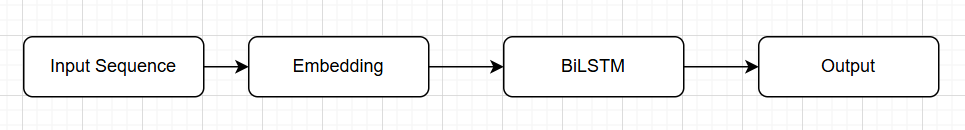

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2024-12-04 01:02:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-04 01:02:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-04 01:02:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Step 1: Integrate Pre-trained Word Embeddings

Why?

Pre-trained embeddings like GloVe or FastText provide rich semantic context and are highly beneficial for tasks like NER.

In [ ]:
#Create an Embedding Matrix:
import numpy as np
import torch

def load_glove_embeddings(glove_path: str, embedding_dim: int):
    """
    Load GloVe embeddings into a dictionary.
    """
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def create_embedding_matrix(word2idx: dict, glove_embeddings: dict, embedding_dim: int):
    """
    Create an embedding matrix for the vocabulary.
    """
    vocab_size = len(word2idx)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Initialize with random values for missing words
            embedding_matrix[idx] = np.random.uniform(-0.1, 0.1, embedding_dim)

    return torch.tensor(embedding_matrix, dtype=torch.float32)
def create_glove_embedding_matrix(ner_dataset, glove_path="glove.6B.100d.txt", embedding_dim=100):
    """
    Creates and returns a GloVe embedding matrix.

    Args:
        ner_dataset: The NERDataset instance containing the word2idx mapping.
        glove_path: Path to the GloVe embeddings file.
        embedding_dim: Dimension of the GloVe embeddings.

    Returns:
        torch.Tensor: The GloVe embedding matrix.
    """
    glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)
    word2idx = ner_dataset.word2idx
    embedding_matrix = create_embedding_matrix(word2idx, glove_embeddings, embedding_dim)
    return embedding_matrix


In [ ]:
!pip install torchcrf
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags, num_layers=1, dropout=0.5):
        super(BiLSTM_CRF, self).__init__()

        # Word Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim // 2, num_layers=num_layers,
            bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.hidden2tag = nn.Linear(hidden_dim, num_tags)
        self.crf = CRF(num_tags, batch_first=True)

    def forward(self, sentences, lengths, tags=None):
        embedded = self.embedding(sentences)
        packed = pack_padded_sequence(embedded, lengths, batch_first=True)
        lstm_out, _ = self.lstm(packed)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        emissions = self.hidden2tag(lstm_out)

        if tags is not None:  # During training
            loss = -self.crf(emissions, tags, mask=(sentences != word2idx["<PAD>"]), reduction='mean')
            return loss
        else:  # During inference
            return self.crf.decode(emissions, mask=(sentences != word2idx["<PAD>"]))

"""
class BiLSTM(nn.Module):
    # 1) Bi directional Long Short Term Memory

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags, num_layers=1, dropout=0.5):
        super(BiLSTM, self).__init__()

        # Word Embbeddings for Text
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2, num_layers=num_layers,
                            bidirectional = True, batch_first=True,
                            dropout = dropout if num_layers>1 else 0)

        # Linear Layer to map LSTM output to tag spaces
        self.hidden2tag = nn.Linear(hidden_dim, num_tags)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, sentences, lengths):

        # Get embeddings
        embedded = self.dropout(self.embedding(sentences))

        # Pack padded sequences for LSTM
        packed = pack_padded_sequence(embedded, lengths, batch_first=True)

        # Apply LSTM
        lstm_out, _ = self.lstm(packed)

        # Unpack sequences
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)

        # Project to tag space
        tag_space = self.hidden2tag(lstm_out)

        return tag_space
        """


ModuleNotFoundError: No module named 'torchcrf'

## 2.2) BiLSTM Model Training Infrastructure


In [ ]:
def collate_fn(batch):
    # Collate function for DataLoader
    # Pad sequence length in batch to same length

    # Sort the batch in descending order
    batch = sorted(batch, key=lambda x: x[2], reverse=True)

    # Unzip the sorted batch
    sentences, tags, lengths = zip(*batch)

    # Pad sequences in batch
    sentences_padded = pad_sequence(sentences, batch_first=True)
    tags_padded = pad_sequence(tags, batch_first=True)

    return sentences_padded, tags_padded, lengths

In [ ]:
def train_model(model, train_loader, optimizer, criterion, device):
    # Trains model for one epoch
    # Returns average loss

    model.train()
    total_loss = 0
    for batch_sentences, batch_tags, lengths in tqdm(train_loader):
        # move batch to device
        batch_sentences = batch_sentences.to(device)
        batch_tags = batch_tags.to(device)

        # Clear Gradients
        optimizer.zero_grad()

        # Forward Pass
        tag_scores = model(batch_sentences, lengths)

        # # Reshape for loss calculation
        # flattened_scores = tag_scores.view(-1, tag_scores.shape[-1])
        # flattened_tags = batch_tags.view(-1)

        # # Calculate Loss
        # loss = criterion(flattened_scores, flattened_tags)

        # Calculate Loss on Actual Seq Length
        loss = 0
        for i in range(len(lengths)):
            seq_len = lengths[i]
            loss += criterion(tag_scores[i, :seq_len], batch_tags[i, :seq_len])
        loss = loss / len(lengths)

        # Backward Pass and Optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [ ]:
def main():

    # Download and Load Data
    train_path, val_path, test_path = download_conll2003()
    train_sentences, train_tags = load_dataset(train_path)
    val_sentences, val_tags = load_dataset(val_path)

    # Build Vocabularies
    word2idx = build_vocab(train_sentences)
    tag2idx = {tag: idx for idx, tag in enumerate(sorted(set(tag for tags in train_tags for tag in tags)))}


    # Create Dataset
    train_dataset = NERDataset(train_sentences, train_tags, word2idx, tag2idx)
    val_dataset = NERDataset(val_sentences, val_tags, word2idx, tag2idx)

    # Create Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    val_loader= DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Model
    model = BiLSTM(
        vocab_size = len(word2idx),
        embedding_dim = 100,
        hidden_dim = 256,
        num_tags = len(tag2idx),
        num_layers = 5,
        dropout = 0.5
    )

    # Setup Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<PAD>"])
    optimizer = optim.Adam(model.parameters())

    # Training Loop
    num_epochs = 10
    for epoch in range(num_epochs):
        loss = train_model(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    save_model(model, word2idx, tag2idx, "bilstm_ner_model")


if __name__ == "__main__":
    main()

100%|██████████| 469/469 [00:17<00:00, 27.51it/s]


Epoch 1, Loss: 0.7492


100%|██████████| 469/469 [00:13<00:00, 33.66it/s]


Epoch 2, Loss: 0.5415


100%|██████████| 469/469 [00:13<00:00, 33.97it/s]


Epoch 3, Loss: 0.4244


100%|██████████| 469/469 [00:14<00:00, 32.79it/s]


Epoch 4, Loss: 0.3607


100%|██████████| 469/469 [00:14<00:00, 33.46it/s]


Epoch 5, Loss: 0.3213


100%|██████████| 469/469 [00:13<00:00, 33.88it/s]


Epoch 6, Loss: 0.2882


100%|██████████| 469/469 [00:13<00:00, 33.87it/s]


Epoch 7, Loss: 0.2664


100%|██████████| 469/469 [00:13<00:00, 33.81it/s]


Epoch 8, Loss: 0.2446


100%|██████████| 469/469 [00:13<00:00, 33.56it/s]


Epoch 9, Loss: 0.2311


100%|██████████| 469/469 [00:14<00:00, 32.46it/s]

Epoch 10, Loss: 0.2161


## 2.3) Benchmarking Functions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
from typing import List, Tuple, Dict

In [ ]:
def benchmark_model(model, dataloader, word2idx, tag2idx, idx2tag, device):
    """
    Benchmark the NER model and return comprehensive metrics
    """
    model.eval()
    model = model.to(device)
    # Collect true and predicted labels
    true_labels = []
    pred_labels = []
    print_model_output = True
    with torch.no_grad():
        for batch_sentences, batch_tags, lengths in dataloader:
            batch_sentences = batch_sentences.to(device)
            batch_tags = batch_tags.to(device)

            # Get predictions
            # logging.debug(type(batch_sentences))
            model_output = model(batch_sentences, lengths)
            if print_model_output:
                print(model_output)
                print_model_output = False

            # If model returns a list, extract the tag scores
            if isinstance(model_output, list):
                # Try different common list indexing patterns
                if len(model_output) == 2:
                    # Common pattern: [loss, tag_scores] or [hidden_states, tag_scores]
                    tag_scores = model_output[1]
                elif len(model_output) > 2:
                    # If more than 2 elements, try the first two
                    tag_scores = model_output[0]  # or model_output[1]
                else:
                    # Fallback to first element if only one other element exists
                    tag_scores = model_output[0]
            else:
                logging.debug(f"model_output is a {type(model_output)}")
                tag_scores = model_output

            # Ensure tag_scores is a tensor
            if not isinstance(tag_scores, torch.Tensor):
                print(tag_scores)
                # Add debug print to understand the structure
                print("Model output:", model_output)
                print("Tag scores:", tag_scores)
                raise TypeError(f"Expected tag_scores to be a tensor, but got {type(tag_scores)}")

            logging.debug(len(tag_scores))
            predictions = torch.argmax(tag_scores, dim=2)

            # Process batch
            for i in range(len(lengths)):
                seq_len = lengths[i]
                true_labels.extend(batch_tags[i, :seq_len].cpu().numpy())
                pred_labels.extend(predictions[i, :seq_len].cpu().numpy())

    # Dynamically get unique labels from true and predicted labels
    unique_labels = sorted(list(set(true_labels) | set(pred_labels)))
    unique_target_names = [idx2tag[label] for label in unique_labels]

    # Generate classification report
    report = classification_report(
        true_labels,
        pred_labels,
        labels=unique_labels,
        target_names=unique_target_names,
        zero_division=0
    )

    return true_labels, pred_labels, report

In [ ]:
def visualize_confusion_matrix(true_labels, pred_labels, idx2tag):
    """
    Create and save a confusion matrix visualization
    """
    # Get unique labels
    unique_labels = sorted(list(set(true_labels) | set(pred_labels)))

    # Create confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)

    # Get tag names for unique labels
    tag_names = [idx2tag[label] for label in unique_labels]

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=tag_names,
                yticklabels=tag_names)
    plt.title('Confusion Matrix for NER Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('ner_confusion_matrix.png')
    plt.close()

In [ ]:
def detailed_error_analysis(true_labels, pred_labels, idx2tag):
    """
    Perform detailed error analysis
    """
    # Identify misclassified instances
    misclassified = []
    for true, pred in zip(true_labels, pred_labels):
        if true != pred:
            misclassified.append({
                'true_label': idx2tag[true],
                'pred_label': idx2tag[pred]
            })

    # Aggregate misclassification stats
    error_counts = {}
    for error in misclassified:
        key = f"{error['true_label']} -> {error['pred_label']}"
        error_counts[key] = error_counts.get(key, 0) + 1

    # Sort errors by frequency
    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)

    # Print top errors
    print("\nTop Misclassification Patterns:")
    for error, count in sorted_errors[:10]:
        print(f"{error}: {count} times")

    return misclassified, sorted_errors

## 2.4) Loading the Model

In [ ]:
def load_model_and_vocab(path):
    """
    Load the saved model and vocabularies
    """
    # Load vocabularies
    with open(f"{path}_vocab.json", 'r') as f:
        vocab_data = json.load(f)

    word2idx = vocab_data['word2idx']
    tag2idx = vocab_data['tag2idx']
    idx2tag = {int(k): v for k, v in vocab_data['idx2tag'].items()}  # Convert back to int

    # Initialize model with same parameters
    model = BiLSTM(
        vocab_size=len(word2idx),
        embedding_dim=100,
        hidden_dim=256,
        num_tags=len(tag2idx),
        num_layers=1,
        dropout=0.5
    )

    model.load_state_dict(torch.load(f"{path}_state.pt", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
    return model, word2idx, tag2idx, idx2tag

## 2.5) Benchmarking and Results

In [ ]:
def main():
    # Load model and data
    model, word2idx, tag2idx, idx2tag = load_model_and_vocab(path= "bilstm_ner_model")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Load test data
    _, test_path, _ = download_conll2003()
    test_sentences, test_tags = load_dataset(test_path)

    # Create test dataset
    test_dataset = NERDataset(test_sentences, test_tags, word2idx, tag2idx)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Benchmark model
    true_labels, pred_labels, report = benchmark_model(
        model, test_loader, word2idx, tag2idx, idx2tag, device
    )

    # Print classification report
    print("\nClassification Report:")
    print(report)

    # Visualize confusion matrix
    visualize_confusion_matrix(true_labels, pred_labels, idx2tag)

    # Perform error analysis
    misclassified, sorted_errors = detailed_error_analysis(
        true_labels, pred_labels, idx2tag
    )

if __name__ == "__main__":
    main()

<ipython-input-16-99dbc8d6d6bc>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{path}_state.pt", map_location=torch.device("cuda" if to

tensor([[[-7.6655e+00, -5.1509e+00, -7.1686e+00,  ..., -1.9231e+00,
          -2.0922e+00,  7.2411e+00],
         [-8.5205e+00, -5.0456e+00, -7.4655e+00,  ..., -1.0728e+00,
          -1.1730e+00,  3.9588e+00],
         [-9.8689e+00, -4.6285e+00, -8.4453e+00,  ...,  2.5446e-01,
          -1.7670e+00, -1.1796e-01],
         ...,
         [-8.2645e+00, -3.7462e+00, -6.2851e+00,  ..., -1.0080e+00,
          -4.6946e+00,  6.2303e+00],
         [-7.2041e+00, -3.8327e+00, -5.2023e+00,  ...,  1.1681e+00,
          -1.5961e+00, -1.0990e-01],
         [-6.2278e+00, -4.5997e+00, -4.1856e+00,  ..., -4.5869e-01,
          -4.9862e+00,  5.5000e+00]],

        [[-7.1497e+00, -5.1568e+00, -7.1580e+00,  ..., -2.8499e+00,
          -9.2625e-01,  6.2338e+00],
         [-8.3714e+00, -5.2705e+00, -7.2493e+00,  ..., -1.7496e+00,
          -3.5310e+00,  8.1561e+00],
         [-9.8570e+00, -5.2158e+00, -8.1329e+00,  ..., -6.9026e-01,
          -2.7578e+00,  6.3544e+00],
         ...,
         [-9.0187e+00, -6

# 3) BiLSTM CRF Model

## 3.1) BiLSTM CRF Model Architecture

In [ ]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim=100,
                 hidden_dim=128, num_lstm_layers=1, dropout=0.5):
        super(BiLSTM_CRF, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        # Word embeddings layer
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                           num_layers=num_lstm_layers,
                           bidirectional=True,
                           dropout=dropout if num_lstm_layers > 1 else 0,
                           batch_first=True)

        # Maps the output of the LSTM into tag space
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters
        # transitions[i,j] is the score of transitioning from j to i
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce constraints on the transition parameters
        self.transitions.data[tag_to_ix['START'], :] = -10000
        self.transitions.data[:, tag_to_ix['STOP']] = -10000

        self.dropout = nn.Dropout(dropout)

    def _forward_alg(self, feats):
        # Ensure forward_var is on the same device as feats
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(feats.device)
        init_alphas[0][self.tag_to_ix['START']] = 0.

        forward_var = init_alphas

        for feat in feats:
            alphas_t = []
            for next_tag in range(self.tagset_size):
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                trans_score = self.transitions[next_tag].view(1, -1)
                next_tag_var = forward_var + trans_score + emit_score
                alphas_t.append(torch.logsumexp(next_tag_var, dim=1).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix['STOP']]
        return torch.logsumexp(terminal_var, dim=1)

    def _score_sentence(self, feats, tags):
        # Ensure tags are on the same device as feats
        score = torch.zeros(1, device=feats.device)
        start_tag = torch.tensor([self.tag_to_ix['START']], dtype=torch.long, device=tags.device)
        tags = torch.cat([start_tag, tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix['STOP'], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Ensure initial variables are on the same device as feats
        init_vvars = torch.full((1, self.tagset_size), -10000., device=feats.device)
        init_vvars[0][self.tag_to_ix['START']] = 0

        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []
            viterbivars_t = []

            # Ensure transitions are on the same device
            transitions = self.transitions.to(feats.device)

            for next_tag in range(self.tagset_size):
                next_tag_var = forward_var + transitions[next_tag]
                best_tag_id = torch.argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))

            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        terminal_var = forward_var + transitions[self.tag_to_ix['STOP']]
        best_tag_id = torch.argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)

        start = best_path.pop()
        assert start == self.tag_to_ix['START']
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags, lengths):
        # Get BiLSTM features
        embeds = self.word_embeds(sentence)
        embeds = self.dropout(embeds)

        packed_embeds = pack_padded_sequence(embeds, lengths,
                                        batch_first=True,
                                        enforce_sorted=False)

        packed_lstm_out, _ = self.lstm(packed_embeds)
        lstm_out, _ = pad_packed_sequence(packed_lstm_out, batch_first=True)

        lstm_out = self.dropout(lstm_out)
        lstm_feats = self.hidden2tag(lstm_out)

        # Calculate loss for the batch
        total_loss = torch.zeros(1, device=sentence.device)
        for i, length in enumerate(lengths):
            feats = lstm_feats[i][:length]
            forward_score = self._forward_alg(feats)
            gold_score = self._score_sentence(feats, tags[i][:length])
            total_loss += forward_score - gold_score

        return total_loss / len(lengths)

    def forward(self, sentence, lengths):
        # Get BiLSTM features
        embeds = self.word_embeds(sentence)
        packed_embeds = pack_padded_sequence(embeds, lengths,
                                           batch_first=True,
                                           enforce_sorted=False)

        packed_lstm_out, _ = self.lstm(packed_embeds)
        lstm_out, _ = pad_packed_sequence(packed_lstm_out, batch_first=True)
        lstm_feats = self.hidden2tag(lstm_out)

        # Find the best path for the batch
        all_paths = []
        all_scores = []
        for i, length in enumerate(lengths):
            feats = lstm_feats[i][:length]
            score, path = self._viterbi_decode(feats)
            all_paths.append(path)
            all_scores.append(score)

        return all_scores, all_paths

## 3.2) BiLSTM CRF Model Training Infrastructure


In [ ]:
def prepare_sequence(seq, to_ix):
    return torch.tensor([to_ix[w] for w in seq], dtype=torch.long)

# Training function
def train_bilstmcrf_model(model, train_data, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for sentence, tags in train_data:
            # Clear gradients
            model.zero_grad()

            # Get the lengths of sequences in batch
            lengths = [len(s) for s in sentence]

            # Prepare input
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)

            # Forward pass
            loss = model.neg_log_likelihood(sentence_in, targets, lengths)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_data):.4f}')

In [ ]:
def train_bilstmcrf_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch_sentences, batch_tags, lengths in train_loader:
        # Move to device
        batch_sentences = batch_sentences.to(device)
        batch_tags = batch_tags.to(device)

        # Clear gradients
        model.zero_grad()

        # Calculate loss
        loss = model.neg_log_likelihood(batch_sentences, batch_tags, lengths)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# New evaluation function
def evaluate_bilstmcrf(model, val_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch_sentences, batch_tags, lengths in val_loader:
            # Move to device
            batch_sentences = batch_sentences.to(device)
            batch_tags = batch_tags.to(device)

            # Calculate loss
            loss = model.neg_log_likelihood(batch_sentences, batch_tags, lengths)
            total_loss += loss.item()

    return total_loss / len(val_loader)

# Modified collate function to handle CRF requirements
def create_collate_fn(word2idx, tag2idx):
    def collate_fn_bilstmcrf(batch):
        # Unpack only sentences and tags
        sentences = [item[0] for item in batch]
        tags = [item[1] for item in batch]

        # Sort batch by sequence length (required for packed sequences)
        sorted_indices = sorted(range(len(sentences)),
                                key=lambda k: len(sentences[k]),
                                reverse=True)

        sentences = [sentences[i] for i in sorted_indices]
        tags = [tags[i] for i in sorted_indices]

        # Get sequence lengths
        lengths = [len(s) for s in sentences]

        # Pad sequences
        padded_sentences = pad_sequence([torch.tensor(s) for s in sentences],
                                        batch_first=True,
                                        padding_value=word2idx['<PAD>'])
        padded_tags = pad_sequence([torch.tensor(t) for t in tags],
                                   batch_first=True,
                                   padding_value=tag2idx['<PAD>'])

        return padded_sentences, padded_tags, lengths

    return collate_fn_bilstmcrf


In [ ]:
def main():
    # Download and Load Data
    train_path, val_path, test_path = download_conll2003()
    train_sentences, train_tags = load_dataset(train_path)
    val_sentences, val_tags = load_dataset(val_path)

    # Build Vocabularies
    word2idx = build_vocab(train_sentences)
    # Need to add START and STOP tags for CRF
    tags = sorted(set(tag for tags in train_tags for tag in tags))
    tag2idx = {
        'START': 0,
        'STOP': 1,
        '<PAD>': 2
    }
    tag2idx.update({tag: idx + 3 for idx, tag in enumerate(tags)})

    # Create Dataset
    train_dataset = NERDataset(train_sentences, train_tags, word2idx, tag2idx)
    val_dataset = NERDataset(val_sentences, val_tags, word2idx, tag2idx)

    # Create Dataloaders
    collate_fn_bilstmcrf = create_collate_fn(word2idx, tag2idx)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_bilstmcrf)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_bilstmcrf)

    # Model
    model = BiLSTM_CRF(  # Changed from BiLSTM to BiLSTM_CRF
        vocab_size=len(word2idx),
        tag_to_ix=tag2idx,  # Changed from num_tags to tag_to_ix
        embedding_dim=100,
        hidden_dim=256,
        num_lstm_layers=1,
        dropout=0.5
    )

    # Setup Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    # Remove criterion as CRF handles loss calculation
    optimizer = optim.Adam(model.parameters())

    # Training Loop
    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss = train_bilstmcrf_epoch(model, train_loader, optimizer, device)
        val_loss = evaluate_bilstmcrf(model, val_loader, device)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    torch.save({
        'model_state_dict': model.state_dict(),
        'word2idx': word2idx,
        'tag2idx': tag2idx
    }, "bilstmcrf_ner_model")

if __name__ == "__main__":
    main()

KeyboardInterrupt: 

## 3.3) Benchmarking Functions


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
from typing import List, Tuple, Dict
import logging

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [ ]:
def benchmark_model(model, dataloader, word2idx, tag2idx, idx2tag, device):
    """
    Benchmark the NER model and return comprehensive metrics
    """
    model.eval()
    model = model.to(device)
    # Collect true and predicted labels
    true_labels = []
    pred_labels = []
    print_model_output = True
    with torch.no_grad():
        for batch_sentences, batch_tags, lengths in dataloader:
            batch_sentences = batch_sentences.to(device)
            batch_tags = batch_tags.to(device)

            # Get predictions
            # logging.debug(type(batch_sentences))
            # model_output = model(batch_sentences, lengths)
            ####
            model_output = torch.tensor(model(batch_sentences, lengths)[0])
            ####
            if print_model_output:
                logging.debug(f"{len(batch_sentences)}, batch_sentences: {batch_sentences}")
                logging.debug(f"{len(batch_tags)}, batch_tag: {batch_tags}")
                logging.debug(f"{len(lengths)}, lengths: {lengths}")
                logging.debug(f"{len(model_output)}, model_output: {model_output}")
                print_model_output = False

            # If model returns a list, extract the tag scores
            if isinstance(model_output, list):
                logging.debug("model_output is a list")
                # Try different common list indexing patterns
                if len(model_output) == 2:
                    # Common pattern: [loss, tag_scores] or [hidden_states, tag_scores]
                    tag_scores = model_output[1]
                elif len(model_output) > 2:
                    # If more than 2 elements, try the first two
                    tag_scores = model_output[0]  # or model_output[1]
                else:
                    # Fallback to first element if only one other element exists
                    tag_scores = model_output[0]
            else:
                logging.debug(f"model_output is not a list. It is a {type(model_output)}")
                tag_scores = model_output

            # Ensure tag_scores is a tensor
            if not isinstance(tag_scores, torch.Tensor):
                # logging.debug(model_output)
                # logging.debug(tag_scores)
                # Add debug print to understand the structure
                print("Model output:", model_output)
                print("Tag scores:", tag_scores)
                raise TypeError(f"Expected tag_scores to be a tensor, but got {type(tag_scores)}")

            logging.debug(f"{len(tag_scores)}, tag_scores: {tag_scores}")
            predictions = torch.argmax(tag_scores, dim=0)
            logging.debug(predictions)

            # Process batch
            for i in range(len(lengths)):
                seq_len = lengths[i]
                true_labels.extend(batch_tags[i, :seq_len].cpu().numpy())
                pred_labels.extend(predictions[i].cpu().numpy())

    # Dynamically get unique labels from true and predicted labels
    unique_labels = sorted(list(set(true_labels) | set(pred_labels)))
    unique_target_names = [idx2tag[label] for label in unique_labels]

    # Generate classification report
    report = classification_report(
        true_labels,
        pred_labels,
        labels=unique_labels,
        target_names=unique_target_names,
        zero_division=0
    )

    return true_labels, pred_labels, report

In [ ]:
def visualize_confusion_matrix(true_labels, pred_labels, idx2tag):
    """
    Create and save a confusion matrix visualization
    """
    # Get unique labels
    unique_labels = sorted(list(set(true_labels) | set(pred_labels)))

    # Create confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)

    # Get tag names for unique labels
    tag_names = [idx2tag[label] for label in unique_labels]

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=tag_names,
                yticklabels=tag_names)
    plt.title('Confusion Matrix for NER Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('ner_confusion_matrix.png')
    plt.close()

In [ ]:
def detailed_error_analysis(true_labels, pred_labels, idx2tag):
    """
    Perform detailed error analysis
    """
    # Identify misclassified instances
    misclassified = []
    for true, pred in zip(true_labels, pred_labels):
        if true != pred:
            misclassified.append({
                'true_label': idx2tag[true],
                'pred_label': idx2tag[pred]
            })

    # Aggregate misclassification stats
    error_counts = {}
    for error in misclassified:
        key = f"{error['true_label']} -> {error['pred_label']}"
        error_counts[key] = error_counts.get(key, 0) + 1

    # Sort errors by frequency
    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)

    # Print top errors
    print("\nTop Misclassification Patterns:")
    for error, count in sorted_errors[:10]:
        print(f"{error}: {count} times")

    return misclassified, sorted_errors

## 3.4) Loading the model

In [ ]:
def load_bilstm_crf_model(path):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load checkpoint
    checkpoint = torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    # Extract vocabularies
    word2idx = checkpoint['word2idx']
    tag2idx = checkpoint['tag2idx']

    # Create reverse tag mapping
    idx2tag = {idx: tag for tag, idx in tag2idx.items()}

    # Initialize model with same parameters as during training
    model = BiLSTM_CRF(
        vocab_size=len(word2idx),
        tag_to_ix=tag2idx,
        embedding_dim=100,  # Ensure these match your training config
        hidden_dim=256,
        num_lstm_layers=1,
        dropout=0.5
    )

    # Load model state
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # Set to evaluation mode

    return model, word2idx, tag2idx, idx2tag

## 3.5) Benchmarking and Results

In [ ]:
def main():
    # Load model and data
    model, word2idx, tag2idx, idx2tag = load_bilstm_crf_model(path= "bilstmcrf_ner_model")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Load test data
    _, test_path, _ = download_conll2003()
    test_sentences, test_tags = load_dataset(test_path)

    # Create test dataset
    test_dataset = NERDataset(test_sentences, test_tags, word2idx, tag2idx)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Benchmark model
    true_labels, pred_labels, report = benchmark_model(
        model, test_loader, word2idx, tag2idx, idx2tag, device
    )

    # Print classification report
    print("\nClassification Report:")
    print(report)

    # Visualize confusion matrix
    visualize_confusion_matrix(true_labels, pred_labels, tag2idx, idx2tag)

    # Perform error analysis
    misclassified, sorted_errors = detailed_error_analysis(
        true_labels, pred_labels, idx2tag
    )

if __name__ == "__main__":
    main()

<ipython-input-44-0810b7e27ee0>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() 

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [ ]:
pwd

'/content'